# Coding a simple temperature index model

Today we are going to code a simple temperature index model. We will start with creating the most basic [degree day model](http://www.antarcticglaciers.org/glaciers-and-climate/numerical-ice-sheet-models/modelling-glacier-melt/) (DDM). After that we will guide you step-by-step to code you own temperature index model. Later on in the turtorial we will add more complexity to the DDM. 

Also if you're new to python and/or a beginner in programming in general, there is no need to worry. We will take this step by step. We will start simple and it will get more challenging as we go. The goal of the activity is to get a grasp of temperature index models and get some hands-on experience (not to finish the notebook: so please go at your own pace). 

Like always, we first load the packages we need. (Though this can be done later, doing it now keeps the document nice and tidy.)

In [1]:
# imports and defaults
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook')

In addition to loading the packages, we will need climate data for our degree day model and mass balance data to calibrate our model. We will use the AWS data at Zhadang:

Click the link to download: [aws_data_zhadang_localtime.nc]()

These data are from a weather station on a glacier in Tibet (Zhadang) that Fabien maintained during his PhD.

Lets have a look what is in the file. As you can see (after executing the next cell) there is are quite some variables in this file, but we will only use what we need. 

In [2]:
# read the data
with xr.open_dataset('aws_data_zhadang_localtime.nc') as ds:
    ds = ds.load()
ds

<xarray.Dataset>
Dimensions:    (time: 16800)
Coordinates:
  * time       (time) datetime64[ns] 2010-10-02 ... 2012-08-31T23:00:00
Data variables:
    PRESSURE   (time) float64 507.1 506.9 506.5 506.3 ... 508.7 509.0 509.1
    ANGLE      (time) float64 2.209 2.231 2.203 2.202 ... 4.176 4.267 4.127
    WINDSPEED  (time) float64 1.5 3.109 3.217 2.839 ... 5.354 5.41 5.889 4.383
    NETRAD     (time) float64 -71.88 -85.91 -78.63 ... -1.855 -1.769 -1.838
    RH         (time) float64 50.12 45.19 59.71 64.13 ... 94.2 94.45 94.57 94.65
    SWIN       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.563 0.0 0.0 0.0 0.0
    SR50       (time) float64 0.917 0.916 0.916 0.916 ... -2.382 -2.366 -2.355
    TEMP       (time) float64 -2.887 -3.223 -3.912 ... -1.454 -1.612 -1.876
    SWOUT      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.563 0.0 0.0 0.0 0.0
    WINDDIR    (time) float64 191.6 185.5 149.4 137.4 ... 329.4 320.0 329.8
    SURFTEMP   (time) float64 -10.69 -11.49 -12.57 ... -1.339 -1.595 -1.88
    PRCP       (time) float64 0.0 0.0 0.0 0.0 ... 0.5621 0.5621 0.5621 0.5621

The data is has a hourly resolution. As the name of the model states, we need daily data in a degree day model. Let's compute that:

In [3]:
# resample to daily
ds = ds.resample(time='D').mean()
ds

<xarray.Dataset>
Dimensions:    (time: 700)
Coordinates:
  * time       (time) datetime64[ns] 2010-10-02 2010-10-03 ... 2012-08-31
Data variables:
    PRESSURE   (time) float64 506.8 506.9 506.4 506.2 ... 508.9 508.6 507.6
    ANGLE      (time) float64 2.225 2.23 2.235 2.249 ... 4.244 4.247 4.217 4.212
    WINDSPEED  (time) float64 2.817 2.612 2.112 2.389 ... 2.831 2.469 3.883
    NETRAD     (time) float64 7.932 5.902 -1.471 1.74 ... -18.17 14.6 5.107
    RH         (time) float64 51.88 65.21 78.93 90.2 ... 81.88 80.41 79.23 86.42
    SWIN       (time) float64 185.0 200.6 160.7 187.1 ... 120.4 170.7 175.3
    SR50       (time) float64 0.9161 0.9158 0.9167 nan ... -2.522 -2.513 -2.448
    TEMP       (time) float64 -1.615 -3.132 -4.43 -7.388 ... 2.249 2.166 0.3051
    SWOUT      (time) float64 123.4 149.8 127.4 165.6 ... 88.11 125.0 139.5
    WINDDIR    (time) float64 201.9 200.2 244.1 299.6 ... 237.5 246.3 287.9
    SURFTEMP   (time) float64 -6.116 -5.872 -6.012 ... -1.119 -1.172 -1.05
    PRCP       (time) float64 0.0 0.0 0.1524 0.2553 ... 0.1013 0.2354 0.5621

There are more variable here than we actually need. Let's have a look at the SR50 variable first. The sonic ranger ([SR50](https://www.campbellsci.com/sr50a)) is a stationary device that measure the changes in surface elevation by measuring the travel return time of a pulse:

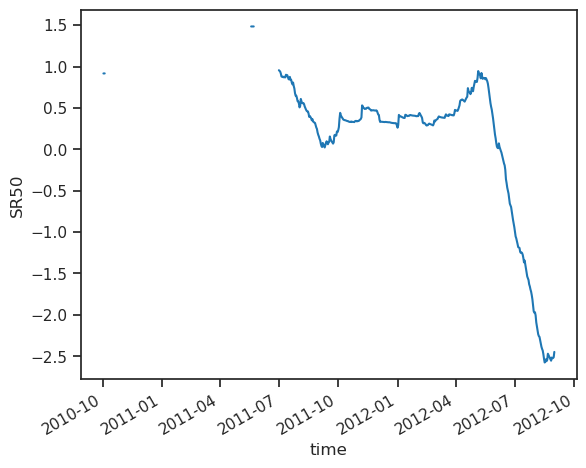

In [4]:
ds.SR50.plot();

As we can see, there is quite some data gaps. This is because the SR50 was buried in snow during the first winter. Therefore, lets focus on the melting season 2012, form May 15th until August 15th:

In [5]:
ds = ds.sel(time=slice('2012-05-15', '2012-08-15'))

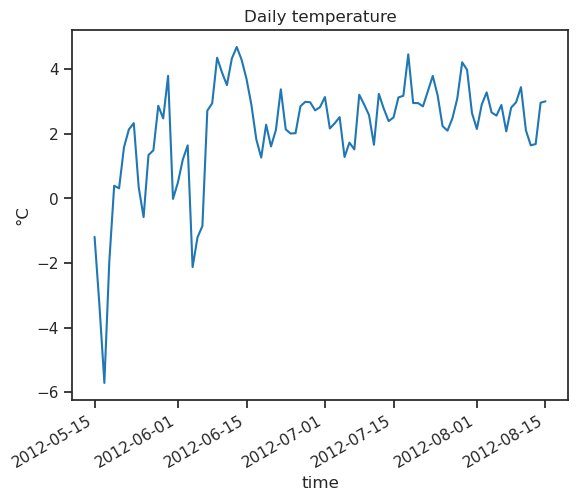

In [6]:
ds.TEMP.plot();
plt.title('Daily temperature'); plt.ylabel('°C');

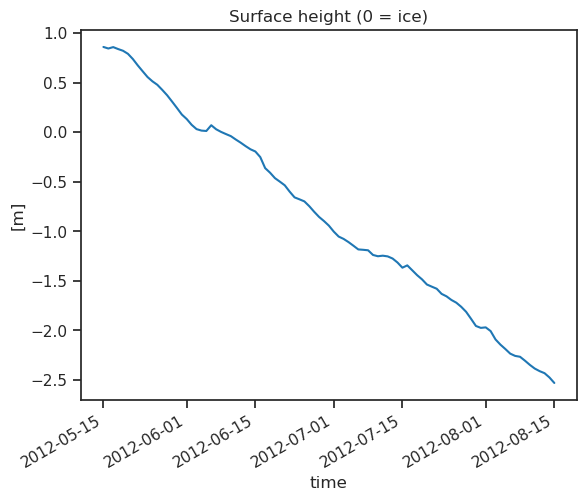

In [7]:
ds.SR50.plot();
plt.title('Surface height (0 = ice)'); plt.ylabel('[m]');

This plot shows surface elevation, but what we want to simulate is melt in units of water. The [usual unit of melt](https://wgms.ch/downloads/Cogley_etal_2011.pdf) is mm water equivalent (or, better: kg m-2). Let us convert surface elevation into melt, using the following density values:
- (snow: 200 kg m-4
- ice/firn: 850 kg m-4

Let us do this for you (no need to understand what is going on):

In [8]:
# No need to understand the code below for now
is_snow = ds.SR50.where(ds.SR50 > 0, -1) > 0
snow_melt = - ds.SR50.where(ds.SR50 > 0, 0) * 200
ice_melt = - ds.SR50.where(ds.SR50 <= 0, 0) * 850
observed_melt = snow_melt + ice_melt - snow_melt.isel(time=0)

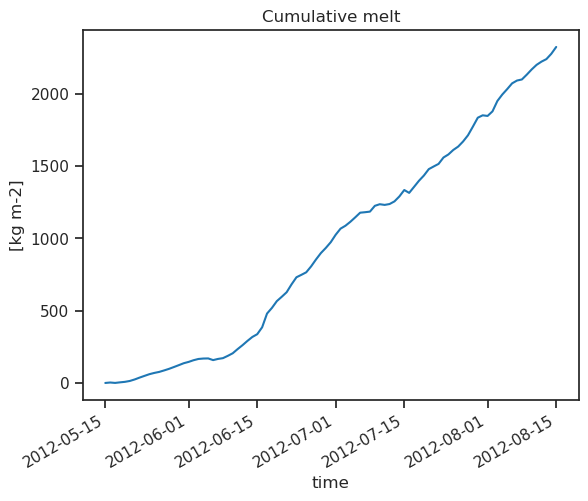

In [9]:
observed_melt.plot();
plt.title('Cumulative melt'); plt.ylabel('[kg m-2]');

As we can see, the melting at the beginning of the season (in presence of snow) is actually slower than the melting of ice (when converted to water equivalent).

## 1. Simplest DDM

For the simplest DDM, we are going to use a single factor for the entire melting period. The DDM formulation is very simple:

$$Melt = f \cdot PDD$$

Where PDD is the sum total of daily average temperatures above 0°C in a given time period and f is a melting factor. Melt is computed in mm water equivalent (w.e. or kg m-2) per day (d-1), and therefore the melt factor has units kg m-2 K-1 d-1. 

Let's start by computing the "positive degree days", which is the sume of temperature above the melt threshold (here 0°):

In [10]:
# The function "where" works as follows: where our statement is true, keep the data. When false, replace by 0
pdd = ds.TEMP.where(ds.TEMP > 0, 0)

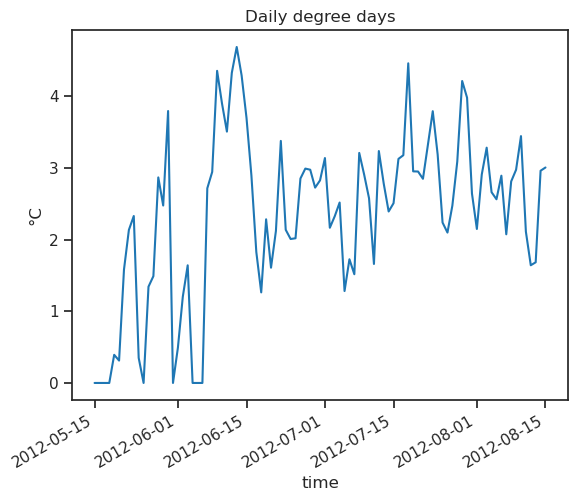

In [11]:
pdd.plot();
plt.title('Daily degree days'); plt.ylabel('°C');

As documented [since quite some time](https://www.sciencedirect.com/science/article/abs/pii/S0022169403002579), "positive degree days" are a good indicator of ice or snow melt over a day. Let's verify this! 

Let's assume that the melt factor is 12.

**Activity: compute daily modelled melt according to the formula above. Then compute the cumulative melt over the period, and plot it on the same graph as the cumulative observed melt.**

*Tip: you will need the [.cumsum()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.cumsum.html) function*

In [12]:
# Your answer here

<div class="alert alert-success">
<details><summary><b>Can't go any further?</b> <i>Click for the answer</i></summary>
<code>
melt_f = 12
modelled_melt = (melt_f * pdd).cumsum()
observed_melt.plot(label='Cumulative melt (observations)')
modelled_melt.plot(label='Cumulative melt (model)')
plt.ylabel('[kg m-2]')
plt.legend();
</code>
</div>

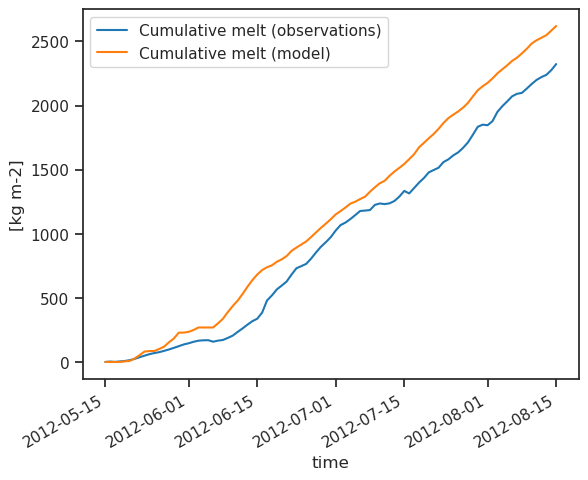

In [13]:
melt_f = 12
modelled_melt = (melt_f * pdd).cumsum()
observed_melt.plot(label='Cumulative melt (observations)')
modelled_melt.plot(label='Cumulative melt (model)')
plt.ylabel('[kg m-2]')
plt.legend();

## 2. Calibrated DDM

Not too bad for a model! But I'm sure we can do a little bit better. First of all, we could compute the melt factor so that observations are matched perfectly (calibration).

**Activity: compute the melt factor so that melt is matched perfectly. Replot your results.**

*Tip: you may need the `.max()` function to compute the total cumulative melt, and you may also need to compute the sum of the positive degree days over the period with `.sum()`.*

In [14]:
# Your answer here

<div class="alert alert-success">
<details><summary><b>Can't go any further?</b> <i>Click for the answer</i></summary>
<code>
optimal_melt_f = observed_melt.max() / pdd.sum()
modelled_melt = (optimal_melt_f * pdd).cumsum()
observed_melt.plot(label='Cumulative melt (observations)')
modelled_melt.plot(label='Cumulative melt (better model)')
plt.ylabel('[kg m-2]')
plt.legend();
</code>
</div>

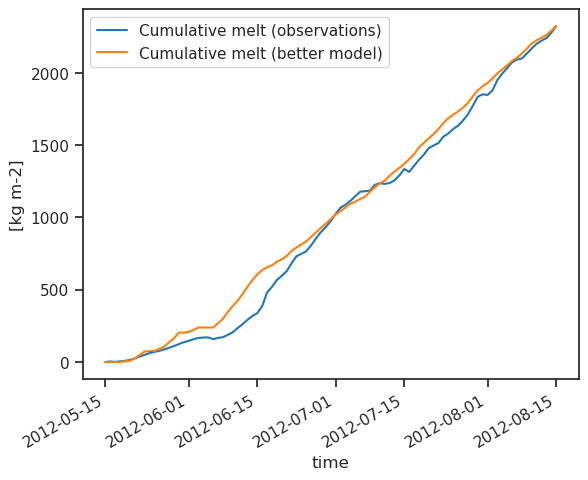

In [15]:
optimal_melt_f = observed_melt.max() / pdd.sum()
modelled_melt = (optimal_melt_f * pdd).cumsum()
observed_melt.plot(label='Cumulative melt (observations)')
modelled_melt.plot(label='Cumulative melt (better model)')
plt.ylabel('[kg m-2]')
plt.legend();

## 3. Optional: different factors for ice and snow 

Even with the perfectly calibrated model, the pergormance in the first half is not very good. This is because we are not distiguishing between the snow surface (which has a higher albedo) from the ice surface. Traditionally, we use different factors for ice and snow.

**Optional activity: if you are a versed python coder, you might be able to code a model which is able to do that. You will need the is_snow variable we computed earlier. You may also compute the optimal parameter yourself, but here is our suggestion for them: snow_factor=6.11, ice_factor=11.22.**

In [16]:
# Your answer here

<div class="alert alert-success">
<details><summary><b>Can't go any further?</b> <i>Click for the answer</i></summary>
<code>
# Compute the snow melt factor
snow_melt = observed_melt[is_snow].max()
snow_factor = snow_melt / pdd[is_snow].sum()
# Compute the ice melt facto
ice_melt = observed_melt[~is_snow].max() - observed_melt[~is_snow].min() 
ice_factor = ice_melt / pdd[~is_snow].sum()
# Total model
best_model_daily = snow_factor * pdd.where(is_snow, 0) + ice_factor * pdd.where(~is_snow, 0)
best_model = best_model_daily.cumsum()
# Plot
observed_melt.plot(label='Cumulative melt (observations)')
best_model.plot(label='Cumulative melt (best model)')
plt.ylabel('[kg m-2]')
plt.legend();
</code>
</div>

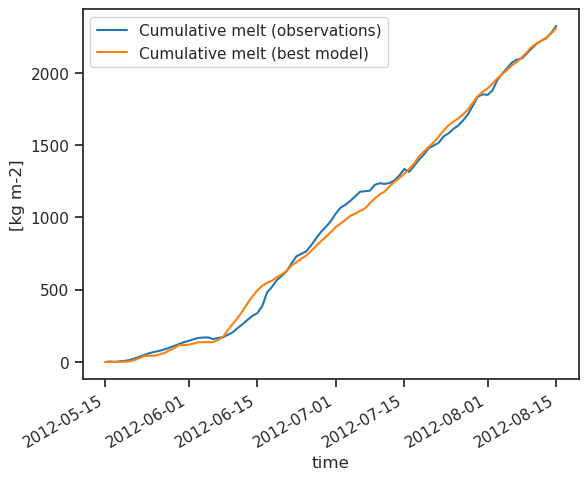

In [17]:
# Compute the snow melt factor
snow_melt = observed_melt[is_snow].max()
snow_factor = snow_melt / pdd[is_snow].sum()
# Compute the ice melt facto
ice_melt = observed_melt[~is_snow].max() - observed_melt[~is_snow].min() 
ice_factor = ice_melt / pdd[~is_snow].sum()
# Total model
best_model_daily = snow_factor * pdd.where(is_snow, 0) + ice_factor * pdd.where(~is_snow, 0)
best_model = best_model_daily.cumsum()
# Plot
observed_melt.plot(label='Cumulative melt (observations)')
best_model.plot(label='Cumulative melt (best model)')
plt.ylabel('[kg m-2]')
plt.legend();

## Final notes

Note that a full mass balance model should take into account both accumulation (snowfall) and ablation (melt). Furthermore, distributed models like OGGM need to simulate the mass-balance at different elevations, which requires other paramters (such as lapse rate). Fundamentally, however, the equations is very simple. If you are interested, [here](https://github.com/OGGM/oggm/blob/ade87f6b5b7f3115800023a57f12b9da59c90d69/oggm/core/massbalance.py#L647) is the code of the equation in OGGM. "Easy", right?

Temperature index models can be extended to include more processes, such as radiation or snow aging. OGGM PhD student Lilian, for example, wrote a model which takes into account the influence of aging of the snow on the melt factor. For this, you'll need to implement a kind of "snowpack" model, where snow height is tracked over time. 

If you are finished early and want to go further, have a look at [this OGGM tutorial](https://oggm.org/tutorials/stable/notebooks/beginner/plot_mass_balance.html) on plotting the mass balance. In two days, we will go deeper into the implementation and calibration of the models in OGGM.